<a href="https://colab.research.google.com/github/Transega/Geocif-Crop-Yield-Prediction-/blob/main/Geocif_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Geocif Training project attempt: Collins Asega** 

# Install the Libraries 

In [ ]:
!pip install catboost
!pip install merf
!pip install shap
!pip install shapash
!pip install tsfresh
# !pip install scipy

     |████████████████████████████████| 76.4 MB 22 kB/s 
     |████████████████████████████████| 371 kB 8.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509236 sha256=c9f1c345fdd853b66b93ed996c822edeaf885301800f400400536a46bbd37262
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap
     |████████████████████████████████| 877 kB 8.2 MB/s 
     |████████████████████████████████| 75 kB 3.4 MB/s 
     |████████████████████████████████| 99 kB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 35.8 MB/s 
     |████████████████████████████████| 188 kB 47.6 MB/s 
     |████████████████████████████████| 3.5 MB 55.6 MB/s 
 

In [ ]:
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# !pip install scipy>=1.5

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
# Read in data, compute features, train model
data = pd.read_csv('/content/drive/MyDrive/data_training/kenya_maize_s1.csv')

# subset to when crop is actively growing i.e. crop_cal != 0
data = data[data['crop_cal'] > 0]
#  inspect to see the various features available in the data 
data.describe()

,Unnamed: 0,str_ID,Year,JD,crop_cal,yield,production,tot_pix,mean_crop,med_crop,min_crop,max_crop,ndvi,ndvi_tot_pix,ndvi_wa_crop,ndvi_wmed_crop,ndvi_min_crop,ndvi_max_crop,cpc_tmin,cpc_tmin_tot_pix,cpc_tmin_wa_crop,cpc_tmin_wmed_crop,cpc_tmin_min_crop,cpc_tmin_max_crop,cpc_tmax,cpc_tmax_tot_pix,cpc_tmax_wa_crop,cpc_tmax_wmed_crop,cpc_tmax_min_crop,cpc_tmax_max_crop,chirps,chirps_tot_pix,chirps_wa_crop,chirps_wmed_crop,chirps_min_crop,chirps_max_crop,esi_4wk,esi_4wk_tot_pix,esi_4wk_wa_crop,esi_4wk_wmed_crop,esi_4wk_min_crop,esi_4wk_max_crop,soil_moisture_as1,soil_moisture_as1_tot_pix,soil_moisture_as1_wa_crop,soil_moisture_as1_wmed_crop,soil_moisture_as1_min_crop,soil_moisture_as1_max_crop,Month,Day,Season,perc_season,GDD,cGDD,cNDVI
count,36570.000000,3.657000e+04,36570.00000,36570.000000,36570.000000,21249.000000,21249.000000,36570.000000,36570.000000,36570.000000,36570.000000,36570.000000,34553.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,34590.000000,34590.000000,34590.000000,34590.000000,34590.000000,34590.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34602.000000,25142.000000,25142.000000,25142.000000,25142.000000,25142.000000,32748.000000,4689.00000,4689.000000,4689.000000,4689.000000,4689.000000,18789.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,36570.000000,36570.000000,36570.00000,0.0,34582.000000,34582.000000,34553.000000
mean,38411.320755,8.900508e+07,2011.00000,183.735849,1.810063,1.618647,1.618647,561.842767,7798.181333,8456.996855,2241.478616,9488.267925,164.580267,458.204219,7867.373699,8452.171860,2571.812320,9371.240412,16.449000,559.414166,7787.347320,8445.029199,2240.296386,9482.498179,26.851615,559.535076,7787.417670,8445.108467,2240.303366,9482.532242,3.696819,192.533450,8233.388611,8956.108862,2248.963169,9752.140005,0.078153,542.29132,7863.354480,8433.099168,2460.332054,9470.822563,12.235332,549.806198,7802.685242,8433.215157,2239.256262,9477.421965,6.560377,15.792453,2011.00000,NaN,12.413135,10030.212124,126002.533627
std,19522.265370,2.302743e+03,6.63334,79.508450,0.834277,0.825780,0.825780,481.068583,1972.886412,2272.640070,222.504559,1396.432173,23.654452,422.531350,2049.960006,2308.456571,789.487733,1682.135370,3.764438,481.229670,1977.846650,2279.812559,222.046882,1403.219990,3.431242,481.262093,1977.813047,2279.762787,222.049607,1403.180093,6.363449,226.910101,1610.087246,1820.204536,234.649617,1018.409267,0.895980,480.14995,2051.518973,2286.601342,597.435203,1426.262931,7.398609,482.749550,2003.728668,2287.339931,221.652660,1409.237148,2.584423,8.829086,6.63334,NaN,2.220256,5763.529286,74056.291624
min,59.000000,8.900100e+07,2000.00000,60.000000,1.000000,0.042000,0.042000,14.000000,3004.043478,2777.000000,2040.000000,5238.000000,89.291179,1.000000,2380.000000,2244.000000,2040.000000,2380.000000,-18.839827,8.000000,3004.043478,2777.000000,2040.000000,5238.000000,13.009275,14.000000,3004.043478,2777.000000,2040.000000,5238.000000,0.000000,1.000000,3004.043478,2777.000000,2040.000000,5238.000000,-2.699216,3.00000,2618.571429,2533.500000,2040.000000,3333.000000,1.849637,14.000000,3004.043478,2777.000000,2040.000000,5238.000000,3.000000,1.000000,2000.00000,NaN,4.024504,9.511460,142.496170
25%,21709.250000,8.900300e+07,2005.00000,121.000000,1.000000,0.839000,0.839000,250.000000,6365.486486,6635.000000,2040.000000,10000.000000,151.878239,186.000000,6595.058344,6938.000000,2040.000000,10000.000000,13.701684,250.000000,6365.486486,6635.000000,2040.000000,10000.000000,24.410697,250.000000,6365.486486,6635.000000,2040.000000,10000.000000,0.000000,25.000000,7700.477169,8979.000000,2040.000000,10000.000000,-0.551281,245.00000,6395.849020,6635.000000,2040.000000,10000.000000,4.961773,250.000000,6365.486486,6635.000000,2040.000000,10000.000000,5.000000,8.000000,2005.00000,NaN,10.813747,5151.383720,63940.568991
50%,42934.500000,8.900600e+07,2011.00000,170.500000,2.000000,1.606000,1.606000,441.000000,8884.533693,10000.000000,2142.00

In [ ]:
# drop null values 
# subset to when crop is actively growing i.e. crop_cal != 0
data = data[data['crop_cal'] > 0]


In [ ]:

# Select Features from data frame 
var = data[['mean_crop','yield','ndvi_wmed_crop' , 'cpc_tmin','chirps', 'cGDD']]


# var = var.dropna(subset=['mean_crop','yield','ndvi_wmed_crop' , 'cpc_tmin','chirps'])
# var.describe()

# var = var.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)
var = var.dropna(subset=['mean_crop','ndvi_wmed_crop' , 'cpc_tmin','chirps', 'cGDD','yield'])

var.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2630 entries, 794 to 64964
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mean_crop       2630 non-null   float64
 1   yield           2630 non-null   float64
 2   ndvi_wmed_crop  2630 non-null   float64
 3   cpc_tmin        2630 non-null   float64
 4   chirps          2630 non-null   float64
 5   cGDD            2630 non-null   float64
dtypes: float64(6)
memory usage: 143.8 KB


Feature Extraction 

In [ ]:
#  Create a copy of the data 
df1 = var.copy()

In [ ]:
from tsfresh.feature_extraction import feature_calculators

# variation_coefficient

var.loc[:, 'variation_coef'] = feature_calculators.variation_coefficient(var.values)

In [ ]:
# Look at autocorrrelation
auto_co = var.loc[:, 'autocorrelation'] = feature_calculators.autocorrelation(var.values, 5)

auto_co

9.000000013840175

In [ ]:
# symmetry 
assymmetry = var.loc[:, 'assymetry'] = feature_calculators.time_reversal_asymmetry_statistic(var.values, 1)
assymmetry

460231821.76059246

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters
settings = ComprehensiveFCParameters()
# Set here the options of the settings object as shown in the paragraphs below
# ...
from tsfresh.feature_extraction import extract_features
features = extract_features(df1, column_id='yield',default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 5/5 [00:44<00:00,  8.88s/it]


In [ ]:
features.describe()

invalid value encountered in multiply


,mean_crop__variance_larger_than_standard_deviation,mean_crop__has_duplicate_max,mean_crop__has_duplicate_min,mean_crop__has_duplicate,mean_crop__sum_values,mean_crop__abs_energy,mean_crop__mean_abs_change,mean_crop__mean_change,mean_crop__mean_second_derivative_central,mean_crop__median,mean_crop__mean,mean_crop__length,mean_crop__standard_deviation,mean_crop__variation_coefficient,mean_crop__variance,mean_crop__skewness,mean_crop__kurtosis,mean_crop__root_mean_square,mean_crop__absolute_sum_of_changes,mean_crop__longest_strike_below_mean,mean_crop__longest_strike_above_mean,mean_crop__count_above_mean,mean_crop__count_below_mean,mean_crop__last_location_of_maximum,mean_crop__first_location_of_maximum,mean_crop__last_location_of_minimum,mean_crop__first_location_of_minimum,mean_crop__percentage_of_reoccurring_values_to_all_values,mean_crop__percentage_of_reoccurring_datapoints_to_all_datapoints,mean_crop__sum_of_reoccurring_values,mean_crop__sum_of_reoccurring_data_points,mean_crop__ratio_value_number_to_time_series_length,mean_crop__sample_entropy,mean_crop__maximum,mean_crop__minimum,mean_crop__benford_correlation,mean_crop__time_reversal_asymmetry_statistic__lag_1,mean_crop__time_reversal_asymmetry_statistic__lag_2,mean_crop__time_reversal_asymmetry_statistic__lag_3,mean_crop__c3__lag_1,...,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_4,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_5,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_6,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_7,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_8,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_9,cGDD__ratio_beyond_r_sigma__r_0.5,cGDD__ratio_beyond_r_sigma__r_1,cGDD__ratio_beyond_r_sigma__r_1.5,cGDD__ratio_beyond_r_sigma__r_2,cGDD__ratio_beyond_r_sigma__r_2.5,cGDD__ratio_beyond_r_sigma__r_3,cGDD__ratio_beyond_r_sigma__r_5,cGDD__ratio_beyond_r_sigma__r_6,cGDD__ratio_beyond_r_sigma__r_7,cGDD__ratio_beyond_r_sigma__r_10,cGDD__count_above__t_0,cGDD__count_below__t_0,cGDD__lempel_ziv_complexity__bins_2,cGDD__lempel_ziv_complexity__bins_3,cGDD__lempel_ziv_complexity__bins_5,cGDD__lempel_ziv_complexity__bins_10,cGDD__lempel_ziv_complexity__bins_100,cGDD__fourier_entropy__bins_2,cGDD__fourier_entropy__bins_3,cGDD__fourier_entropy__bins_5,cGDD__fourier_entropy__bins_10,cGDD__fourier_entropy__bins_100,cGDD__permutation_entropy__dimension_3__tau_1,cGDD__permutation_entropy__dimension_4__tau_1,cGDD__permutation_entropy__dimension_5__tau_1,cGDD__permutation_entropy__dimension_6__tau_1,cGDD__permutation_entropy__dimension_7__tau_1,cGDD__query_similarity_count__query_None__threshold_0.0,"cGDD__matrix_profile__feature_""min""__threshold_0.98","cGDD__matrix_profile__feature_""max""__threshold_0.98","cGDD__matrix_profile__feature_""mean""__threshold_0.98","cGDD__matrix_profile__feature_""median""__threshold_0.98","cGDD__matrix_profile__feature_""25""__threshold_0.98","cGDD__matrix_profile__feature_""75""__threshold_0.98"
count,102.0,102.0,102.0,102.0,102.000000,1.020000e+02,102.0,102.0,102.0,102.000000,102.000000,102.000000,1.020000e+02,1.020000e+02,1.020000e+02,102.0,102.0,102.000000,102.0,102.000000,102.000000,102.000000,102.000000,102.0,102.0,102.0,102.0,102.0,102.0,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.0,102.0,1.020000e+02,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.0,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,0.0,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.0,1.0,1.0,1.0,207720.849938,1.767198e+09,0.0,0.0,0.0,7758.167378,7758.167378,25.784314,1.163618e-12,1.492743e-16,1.859129e-24,0.0,0.0,7758.167378,0.0,10.196078,11.254902,11.254902,10.196078,1.0,0.0,1.0,0.0,1.0,1.0

In [ ]:
features.head(10)

,mean_crop__variance_larger_than_standard_deviation,mean_crop__has_duplicate_max,mean_crop__has_duplicate_min,mean_crop__has_duplicate,mean_crop__sum_values,mean_crop__abs_energy,mean_crop__mean_abs_change,mean_crop__mean_change,mean_crop__mean_second_derivative_central,mean_crop__median,mean_crop__mean,mean_crop__length,mean_crop__standard_deviation,mean_crop__variation_coefficient,mean_crop__variance,mean_crop__skewness,mean_crop__kurtosis,mean_crop__root_mean_square,mean_crop__absolute_sum_of_changes,mean_crop__longest_strike_below_mean,mean_crop__longest_strike_above_mean,mean_crop__count_above_mean,mean_crop__count_below_mean,mean_crop__last_location_of_maximum,mean_crop__first_location_of_maximum,mean_crop__last_location_of_minimum,mean_crop__first_location_of_minimum,mean_crop__percentage_of_reoccurring_values_to_all_values,mean_crop__percentage_of_reoccurring_datapoints_to_all_datapoints,mean_crop__sum_of_reoccurring_values,mean_crop__sum_of_reoccurring_data_points,mean_crop__ratio_value_number_to_time_series_length,mean_crop__sample_entropy,mean_crop__maximum,mean_crop__minimum,mean_crop__benford_correlation,mean_crop__time_reversal_asymmetry_statistic__lag_1,mean_crop__time_reversal_asymmetry_statistic__lag_2,mean_crop__time_reversal_asymmetry_statistic__lag_3,mean_crop__c3__lag_1,...,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_4,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_5,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_6,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_7,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_8,cGDD__energy_ratio_by_chunks__num_segments_10__segment_focus_9,cGDD__ratio_beyond_r_sigma__r_0.5,cGDD__ratio_beyond_r_sigma__r_1,cGDD__ratio_beyond_r_sigma__r_1.5,cGDD__ratio_beyond_r_sigma__r_2,cGDD__ratio_beyond_r_sigma__r_2.5,cGDD__ratio_beyond_r_sigma__r_3,cGDD__ratio_beyond_r_sigma__r_5,cGDD__ratio_beyond_r_sigma__r_6,cGDD__ratio_beyond_r_sigma__r_7,cGDD__ratio_beyond_r_sigma__r_10,cGDD__count_above__t_0,cGDD__count_below__t_0,cGDD__lempel_ziv_complexity__bins_2,cGDD__lempel_ziv_complexity__bins_3,cGDD__lempel_ziv_complexity__bins_5,cGDD__lempel_ziv_complexity__bins_10,cGDD__lempel_ziv_complexity__bins_100,cGDD__fourier_entropy__bins_2,cGDD__fourier_entropy__bins_3,cGDD__fourier_entropy__bins_5,cGDD__fourier_entropy__bins_10,cGDD__fourier_entropy__bins_100,cGDD__permutation_entropy__dimension_3__tau_1,cGDD__permutation_entropy__dimension_4__tau_1,cGDD__permutation_entropy__dimension_5__tau_1,cGDD__permutation_entropy__dimension_6__tau_1,cGDD__permutation_entropy__dimension_7__tau_1,cGDD__query_similarity_count__query_None__threshold_0.0,"cGDD__matrix_profile__feature_""min""__threshold_0.98","cGDD__matrix_profile__feature_""max""__threshold_0.98","cGDD__matrix_profile__feature_""mean""__threshold_0.98","cGDD__matrix_profile__feature_""median""__threshold_0.98","cGDD__matrix_profile__feature_""25""__threshold_0.98","cGDD__matrix_profile__feature_""75""__threshold_0.98"
0.042,0.0,1.0,1.0,1.0,57076.826087,1.714613e+08,0.0,0.0,0.0,3004.043478,3004.043478,19.0,4.547474e-13,1.513784e-16,2.067952e-25,0.0,0.0,3004.043478,0.0,19.0,0.0,0.0,19.0,1.0,0.0,1.0,0.0,1.0,1.0,3004.043478,57076.826087,0.052632,0.117783,3004.043478,3004.043478,0.062915,0.0,0.0,0.0,2.710932e+10,...,0.103491,0.109409,0.115398,0.121503,0.127540,0.066081,0.736842,0.421053,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.315789,0.421053,0.578947,0.736842,1.0,0.325083,0.325083,0.325083,0.325083,0.940448,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
0.186,0.0,1.0,1.0,1.0,54072.782609,1.624370e+08,0.0,0.0,0.0,3004.043478,3004.043478,18.0,4.547474e-13,1.513784e-16,2.067952e-25,0.0,0.0,3004.043478,0.0,18.0,0.0,0.0,18.0,1.0,0.0,1.0,0.0,1.0,1.0,3004.043478,54072.782609,0.055556,0.125163,3004.043478,3004.043478,0.062915,0.0,0.0,0.0,2.710932e+10,...,0.109899,0.116371,0.124511,0.132631,0.068807,0.070494,0.666667,0.444444,0.111111,0.0,0.0,0

Run Random Forest Model 

In [ ]:
# Random forest
model = RandomForestRegressor(n_estimators=200)  # 100 is default value for n_estimators

In [ ]:
# Split the dataframe such that we use 70% of the data for training and predict on the remaining 20%
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size=0.3)

In [ ]:
df1

,mean_crop,yield,ndvi_wmed_crop,cpc_tmin,chirps,cGDD
794,8884.533693,1.212,10000.0,13.911002,1.006067,66.676902
802,8884.533693,1.212,10000.0,12.485395,0.000000,149.038975
810,8884.533693,1.212,9174.5,12.152578,0.000000,237.178575
818,8884.533693,1.212,8611.0,13.988485,0.000000,326.543045
826,8884.533693,1.212,10000.0,14.918971,0.985184,420.998313
...,...,...,...,...,...,...
64932,9674.312000,2.425,10000.0,14.884531,4.714965,19288.390052
64940,9674.312000,2.425,10000.0,15.205432,2.280402,19384.417555
64948,9674.312000,2.425,10000.0,14.415150,0.388167,19476.530033
64956,9674.312000,2.425,10000.0,13.767635,0.000000,19570.881748


Define the columns for training and testing and fit the data to the model 

In [ ]:
feature_names = ['mean_crop', 'ndvi_wmed_crop', 'cpc_tmin', 'chirps','cGDD']
X = train[feature_names].values
y = train['yield'].ravel()
X_test = test[feature_names].values
y_test = test['yield'].ravel()

# Fit the model
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X_test),columns=['yield'],index=test.index)

# Inspect the prediction 
y_pred.describe()

,yield
count,789.000000
mean,1.598268
std,0.773317
min,0.183260
25%,0.885535
50%,1.572360
75%,2.371210
max,2.968250


In [ ]:
#  inspect the testing data as well for the yield
y_n = pd.DataFrame(y_test, columns=['yield'])
y_n.describe()

,yield
count,789.000000
mean,1.596158
std,0.851232
min,0.042000
25%,0.826000
50%,1.580000
75%,2.425000
max,3.374000


Looking into the Model Results 

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=5)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

Text(0, 0.5, 'Mean accuracy decrease')

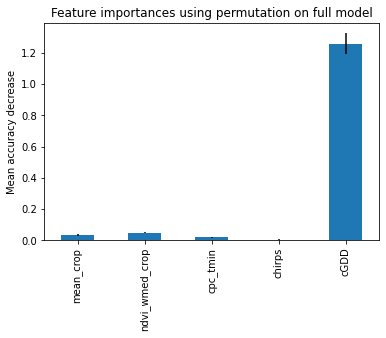

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")

In [ ]:
from shapash.explainer.smart_explainer import SmartExplainer
xpl = SmartExplainer()

xpl.compile(
    x=test[feature_names],
    model=model,
    y_pred=y_pred
)

Backend: Shap TreeExplainer


In [ ]:
xpl.plot.features_importance()

In [ ]:
# Checking for feature contribution
# A feature contribution plot answers questions about how a feature value influences model outcomes 

xpl.plot.contribution_plot("cGDD")

In [ ]:

xpl.plot.contribution_plot("ndvi_wmed_crop")

In [ ]:
xpl.plot.contribution_plot("mean_crop")

In [ ]:
xpl.plot.contribution_plot("chirps")

In [ ]:
xpl.plot.contribution_plot("cpc_tmin")

In [ ]:
# The plot shows features each contributing to push the model output from the base value 
# (the average model output over the training dataset we passed) to the model output. 
summary_df = xpl.to_pandas()
summary_df

,yield,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3,feature_4,value_4,contribution_4,feature_5,value_5,contribution_5
52680,2.495530,cGDD,13754.7,0.733769,ndvi_wmed_crop,9047,0.175949,cpc_tmin,13.9497,-0.0672871,mean_crop,7700.48,0.0340442,chirps,0.447505,-0.00897012
60910,2.410030,cGDD,19257,0.773265,mean_crop,9674.31,0.0470744,ndvi_wmed_crop,10000,-0.0412514,cpc_tmin,15.6462,0.0104495,chirps,0.00421735,-0.00753365
37795,0.528795,cGDD,10142.3,-0.82996,mean_crop,3004.04,-0.134794,ndvi_wmed_crop,2777,-0.091328,chirps,0,-0.0392503,cpc_tmin,21.6282,-0.00389778
63758,2.361935,cGDD,18214.8,0.672076,mean_crop,9674.31,0.0580026,ndvi_wmed_crop,10000,-0.0251518,chirps,9.35597,0.0239026,cpc_tmin,15.5699,0.00508019
38898,0.517840,cGDD,10070.1,-0.875998,mean_crop,3004.04,-0.126653,ndvi_wmed_crop,3061,-0.0848657,chirps,0,-0.0317908,cpc_tmin,22.3212,0.00912101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53911,2.624740,cGDD,15509.7,0.76156,cpc_tmin,10.9467,0.153485,ndvi_wmed_crop,8979,0.116983,chirps,1.9687,-0.0711576,mean_crop,7700.48,0.0358442
906,1.104490,cGDD,1215.84,-0.571504,ndvi_wmed_crop,9166,0.0533777,mean_crop,8884.53,-0.0389306,chirps,4.08349,0.025869,cpc_tmin,11.4125,0.00765157
14014,0.838300,cGDD,2907.59,-0.702964,cpc_tmin,22.518,-0.0813984,ndvi_wmed_crop,6530,0.0529437,chirps,0,-0.0372266,mean_crop,6365.49,-0.0210809
17640,0.964640,cGDD,4801.37,-0.705707,mean_crop,8924.96,-0.0552666,cpc_tmin,19.791,0.0424959,chirps,5.35693,0.042452,ndvi_wmed_crop,10000,0.0126395


In [ ]:
# The plot shows features each contributing to push the model output from the base value 
# (the average model output over the training dataset we passed) to the model output. 
xpl.plot.local_plot(row_num=12)

In [ ]:
# xpl.run_app()
xpl.plot.top_interactions_plot(nb_top_interactions=5)

## **Mixed Effects Random Forest **

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_training/kenya_maize_s1.csv')

df = df[['adm1_name', 'Season','mean_crop','ndvi_wmed_crop' , 'cpc_tmin','chirps', 'cGDD','yield']]

df = df.dropna(subset=['adm1_name', 'Season','mean_crop','ndvi_wmed_crop' , 'cpc_tmin','chirps', 'cGDD','yield'])

df.info()

NameError: ignored

In [ ]:
# Creat e features 
def create_features(key, group):
    percentiles = ['p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90', 'p100']
    vars = ['mean_crop', 'ndvi_wmed_crop', 'cpc_tmin', 'chirps','cGDD']
    
    df_ml = pd.DataFrame()

    group.loc[:, 'Fraction Season'] = range(1, len(group) + 1)
    group.loc[:, 'Fraction Season'] = group.loc[:, 'Fraction Season'] * 100 / len(group)

    for var in vars:
      if var in group:
        for f in percentiles:
          perc = int(f[1:])
          closest = group['Fraction Season'].sub(perc).abs().idxmin()
          df_ml[f'{f}_{var}'] = [group.loc[closest][var]]
    
    df_ml['region'] = key[0]
    df_ml['season'] = key[1]
    df_ml['yield'] = group['yield'].unique()[0]
    df_ml['Season'] = group['Season'].unique()[0]


    return df_ml

In [ ]:
# For each Admin 1 create a column with information on fraction of season
groups = df.groupby(['adm1_name', 'Season'])

frames = []
for key, vals in groups:
    df_group = create_features(key, vals)
    frames.append(df_group)

df_updated = pd.concat(frames)

df_updated.describe()

In [ ]:
df_updated.info()

In [ ]:

df_updated['Season'].unique()
df_updated.columns

In [ ]:
print(len(list_colums))

In [ ]:
# create a list of features from the data 
list_colums = df_updated.columns.tolist()

# print(len(list_colums))
# Generate a list of features 
feature_names_mixed = list_colums[0:50]
feature_names_mixed 

In [ ]:
import numpy as np
from merf.merf import MERF

from sklearn.model_selection import train_test_split
df_train_mx, df_test_mx = train_test_split(df_updated, test_size=0.5)

merf_cluster = 'region'

#  use the feature names generated to subset the training and testing data 
X_mx = df_train_mx[feature_names_mixed].values
y_mx = df_train_mx['yield'].ravel()
X_test_mx = df_test_mx[feature_names_mixed].values
y_test_mx = df_test_mx['yield'].ravel()

model_mx = MERF()

# Mixed Effects Random Forest Training
Z_train = np.ones((len(X_mx), 1))
clusters_train = df_train_mx[merf_cluster]
model_mx.fit(X_mx, Z_train, clusters_train, y_mx)

# Mixed Effects Random Forest Test
Z_test = np.ones((len(X_test_mx), 1))
clusters_test = df_test_mx[merf_cluster]

y_pred_mx = pd.DataFrame(model_mx.predict(X_test_mx, Z_test, clusters_test),
                      columns=['yield'],
                      index=df_test_mx.index)

In [ ]:
result_mx = permutation_importance(model_mx.trained_fe_model, X_test_mx, y_test_mx, n_repeats=10, random_state=42, n_jobs=2)
forest_importances_mx = pd.Series(result_mx.importances_mean, index=feature_names_mixed)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances_mx.plot.bar(yerr=result_mx.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")

Usin the Shapash to understand the results 

## **Compare the results using MAE and MAPE **

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

#
def compare_results(y_true, y_pred):
  abs_e = mean_absolute_error(y_true, y_pred)
  m_sq_e = mean_squared_error(y_true, y_pred)
  m_sq_lg_e = mean_squared_log_error(y_true, y_pred)
  # m_ab_per_E = mean_absolute_percentage_error(y_true, y_pred)
  median_ab_e = median_absolute_error(y_true, y_pred)
  R_score = r2_score(y_true, y_pred)
  
  print('Mean Absolute Error: {}\nMean squared Error :{}\nMean Squared Log Error: {} \nMedian Absolute Error :{} '.format(abs_e, m_sq_e, m_sq_lg_e, median_ab_e ))
  print("R square score ", R_score)

  return [abs_e,m_sq_e,m_sq_lg_e,median_ab_e,R_score]


Compare for Mixed Random Forest 

In [ ]:
compare_mx = compare_results(y_test_mx, y_pred_mx)

Mean Absolute Error: 0.26058026868121686
Mean square Error :0.10849911018005566
Mean Square Log Error: 0.023824221547679138 
Median Absolute Error :0.22967508559256666 
R square score  0.7935153372221017


Compare for the Random forest Model 

In [ ]:
compare_Random_forest = compare_results(y_test, y_pred)

Mean Absolute Error: 0.26082180833685414
Mean square Error :0.11635690926673947
Mean Square Log Error: 0.02049908220494964 
Median Absolute Error :0.2034000000000009 
R square score  0.8392142804597716


In [ ]:
#  Make a datafame for easier comparison
#  create a list of Error metric 
colum = ["Error Metric", "Random Forest", "Mixed Random Forest"]
error_metrics = ["MAE", "MSE", "MSLE", "MEdAE", "R2"]

data_dictionary = {'Error Metric':error_metrics, 'Random Forest':compare_Random_forest, 'Mixed Random Forest':compare_mx}
dataframe = pd.DataFrame(data_dictionary)

***Description of Results*** 

In [ ]:
dataframe

,Error Metric,Random Forest,Mixed Random Forest
0,MAE,0.260822,0.260580
1,MSE,0.116357,0.108499
2,MSLE,0.020499,0.023824
3,MEdAE,0.203400,0.229675
4,R2,0.839214,0.793515


 

1.   From the above dataframe it is Random forest seems to have a higher R squared score compared to the Mixed Random forest model 
2.   in terms of the Median absolute error random forest has a lower value compred to the mixed random Forest 
3. For the Mean Squared Logarithmic error Random forest also seem to have better values 
4. for the Mean Squared Error and the Mean absolute Error, the Mixed Random forest seem to have better value.

In my own assesment I think the Random Forest model performs better, but this could be different maybe if different features were to be chosen. 

 *The results make intiutive sense, since am able to do a yield predictions, and this can be further enhanced by fine tuning the model and using more data to get insights and have it crosschecked with actual produce.*

!!! I wish i could do more but time was not that patient on me but I would reach out on some small aspects kind regards. 

---






